🎯 Бизнес-задача

Предсказать будущие продажи кофе, чтобы:


*   планировать закупки зерна, молока и расходников
*   выявить сезонность спроса


Так как у нас транзакционные данные, нужно сначала агрегировать:

📌 Переводим в формат временного ряда:
дата → суммарные продажи кофе (₽ или количество)

Для бизнеса более важна сумма, поэтому делаем "Прогноз суммы продаж"

In [ ]:
pip install catboost

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ihelon/coffee-sales")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'coffee-sales' dataset.
Path to dataset files: /kaggle/input/coffee-sales


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [5]:
df = pd.read_csv('/kaggle/input/coffee-sales/index_1.csv')
df.head()

,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3636 entries, 0 to 3635
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         3636 non-null   object 
 1   datetime     3636 non-null   object 
 2   cash_type    3636 non-null   object 
 3   card         3547 non-null   object 
 4   money        3636 non-null   float64
 5   coffee_name  3636 non-null   object 
dtypes: float64(1), object(5)
memory usage: 170.6+ KB


In [6]:
df['money'] = df['money'] * 1.89
df

,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,73.1430,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,73.1430,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,73.1430,Hot Chocolate
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,54.6210,Americano
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,73.1430,Latte
...,...,...,...,...,...,...
3631,2025-03-23,2025-03-23 10:34:54.894,card,ANON-0000-0000-1158,67.5864,Cappuccino
3632,2025-03-23,2025-03-23 14:43:37.362,card,ANON-0000-0000-1315,67.5864,Cocoa
3633,2025-03-23,2025-03-23 14:44:16.864,card,ANON-0000-0000-1315,67.5864,Cocoa
3634,2025-03-23,2025-03-23 15:47:28.723,card,ANON-0000-0000-1316,49.0644,Americano


In [7]:
df['coffee_name'].unique()

array(['Latte', 'Hot Chocolate', 'Americano', 'Americano with Milk',
       'Cocoa', 'Cortado', 'Espresso', 'Cappuccino'], dtype=object)

In [8]:
df = df[df['coffee_name'] != 'Cocoa']
df = df[df['coffee_name'] != 'Hot Chocolate']
df['coffee_name'].unique()

array(['Latte', 'Americano', 'Americano with Milk', 'Cortado', 'Espresso',
       'Cappuccino'], dtype=object)

In [9]:
df = df.dropna()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3032 entries, 0 to 3635
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         3032 non-null   object 
 1   datetime     3032 non-null   object 
 2   cash_type    3032 non-null   object 
 3   card         3032 non-null   object 
 4   money        3032 non-null   float64
 5   coffee_name  3032 non-null   object 
dtypes: float64(1), object(5)
memory usage: 165.8+ KB


In [11]:
# кажется, что данные отстортированы по времени, но стоит перестраховаться
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = pd.to_datetime(df['date'])

df = df.sort_values('datetime')
df

,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,73.1430,Latte
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,54.6210,Americano
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,73.1430,Latte
5,2024-03-01,2024-03-01 15:39:47.726,card,ANON-0000-0000-0005,63.8820,Americano with Milk
7,2024-03-01,2024-03-01 18:39:03.580,card,ANON-0000-0000-0007,63.8820,Americano with Milk
...,...,...,...,...,...,...
3629,2025-03-22,2025-03-22 19:16:52.727,card,ANON-0000-0000-1314,58.3254,Americano with Milk
3630,2025-03-23,2025-03-23 10:07:11.278,card,ANON-0000-0000-1196,67.5864,Latte
3631,2025-03-23,2025-03-23 10:34:54.894,card,ANON-0000-0000-1158,67.5864,Cappuccino
3634,2025-03-23,2025-03-23 15:47:28.723,card,ANON-0000-0000-1316,49.0644,Americano


In [12]:
# Создание временных признаков
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek
df['day_of_month'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.month
df['weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Агрегация продаж по часам
hourly_sales = df.groupby(['date', 'hour']).agg({
    'money': 'sum',
    'coffee_name': 'count'
}).reset_index()
hourly_sales.columns = ['date', 'hour', 'revenue', 'coffee_count']

# Агрегация по дням
daily_sales = df.groupby('date').agg({
    'money': 'sum',
    'coffee_name': 'count'
}).reset_index()
daily_sales.columns = ['date', 'revenue', 'coffee_count']

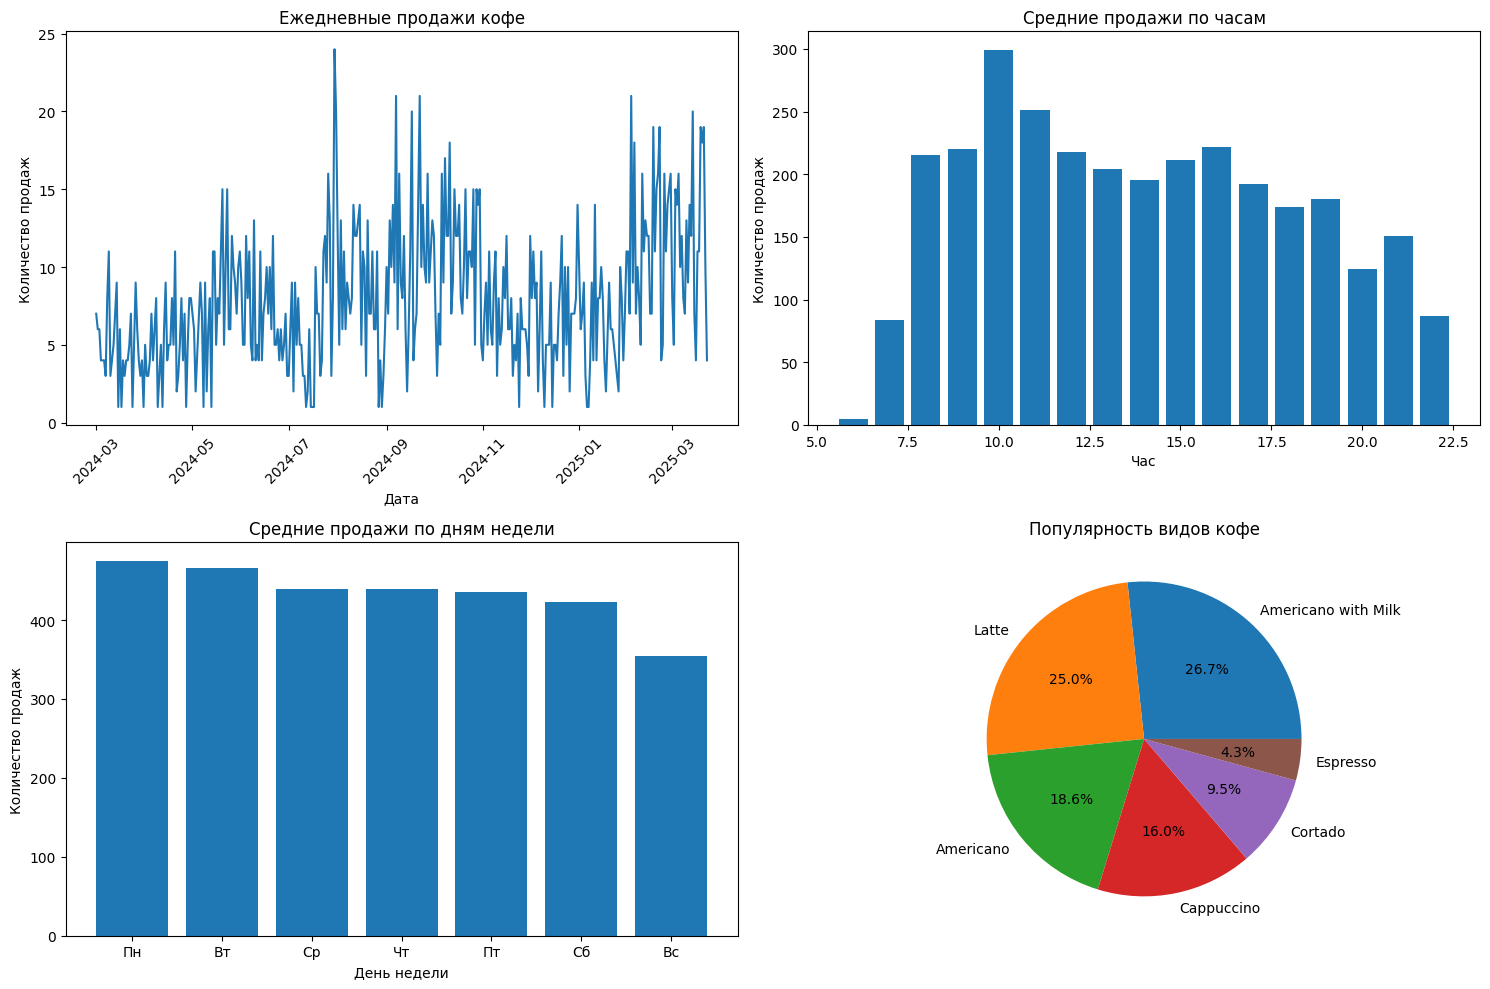

In [13]:
plt.figure(figsize=(15, 10))

# Продажи по дням
plt.subplot(2, 2, 1)
plt.plot(daily_sales['date'], daily_sales['coffee_count'])
plt.title('Ежедневные продажи кофе')
plt.xlabel('Дата')
plt.ylabel('Количество продаж')
plt.xticks(rotation=45)

# Продажи по часам
plt.subplot(2, 2, 2)
hourly_avg = df.groupby('hour')['coffee_name'].count()
plt.bar(hourly_avg.index, hourly_avg.values)
plt.title('Средние продажи по часам')
plt.xlabel('Час')
plt.ylabel('Количество продаж')

# Продажи по дням недели
plt.subplot(2, 2, 3)
daily_avg = df.groupby('day_of_week')['coffee_name'].count()
days = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
plt.bar(days, daily_avg.values)
plt.title('Средние продажи по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество продаж')

# Популярность видов кофе
plt.subplot(2, 2, 4)
coffee_popularity = df['coffee_name'].value_counts()
plt.pie(coffee_popularity.values, labels=coffee_popularity.index, autopct='%1.1f%%')
plt.title('Популярность видов кофе')

plt.tight_layout()
plt.show()

In [14]:
daily_avg = df.groupby('day_of_week')['coffee_name'].count()
daily_avg = (daily_avg / daily_avg.sum()) * 100
daily_avg

,coffee_name
day_of_week,
0,15.666227
1,15.369393
2,14.478892
3,14.478892
4,14.346966
5,13.951187
6,11.708443


# Аналитика продаж кофе

## 1. Динамика продаж
- Нестабильный тренд с сезонными колебаниями

## 2. Распределение по дням недели
- Пн: 15.7% (пик)
- Вт: 15.4%  
- Ср: 14.5%
- Чт: 14.5%
- Пт: 14.3%
- Сб: 14.0%
- Вс: 11.7% (минимум)

## 3. Почасовой анализ
- Пики: 7:00-10:00
- Спады: вечерние и ночные часы

## 4. Рекомендации
- Увеличить ресурсы в Пн и утренние часы
- Стимулировать продажи в ВС
- Оптимизировать меню по топ-позициям
- Скорректировать график работы под пиковую нагрузку

### Ансамбль

In [15]:
def create_features(df, target='coffee_count'):
    '''
    Создание признаков для модели

    :param df: Датафрейм данных
    :param target: Целевая переменная
    :return: Измененный датафрейм
    '''

    df = df.copy()
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['day_of_year'] = df['date'].dt.dayofyear
    df['weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    for i in [1, 2, 3, 7]:
        df[f'lag_{i}'] = df[target].shift(i)

    df['rolling_mean_7'] = df[target].rolling(window=7).mean().shift(1)
    df['rolling_std_7'] = df[target].rolling(window=7).std().shift(1)

    return df

daily_sales_features = create_features(daily_sales)
daily_sales_features = daily_sales_features.dropna()
daily_sales_features

,date,revenue,coffee_count,day_of_week,month,year,day_of_year,weekend,lag_1,lag_2,lag_3,lag_7,rolling_mean_7,rolling_std_7
7,2024-03-08,501.7950,8,4,3,2024,68,0,3.0,4.0,4.0,7.0,4.857143,1.463850
8,2024-03-09,684.1800,11,5,3,2024,69,1,8.0,3.0,4.0,6.0,5.000000,1.732051
9,2024-03-10,173.1240,3,6,3,2024,70,1,11.0,8.0,3.0,6.0,5.714286,2.870208
10,2024-03-11,255.5280,4,0,3,2024,71,0,3.0,11.0,8.0,4.0,5.285714,3.039424
11,2024-03-12,282.3660,5,1,3,2024,72,0,4.0,3.0,11.0,4.0,5.285714,3.039424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,2025-03-19,1043.3556,19,2,3,2025,78,0,11.0,11.0,4.0,14.0,11.285714,5.089672
377,2025-03-20,994.2912,18,3,3,2025,79,0,19.0,11.0,11.0,12.0,12.000000,5.830952
378,2025-03-21,1135.9656,19,4,3,2025,80,0,18.0,19.0,11.0,20.0,12.857143,6.256425
379,2025-03-22,555.4710,10,5,3,2025,81,1,19.0,18.0,19.0,7.0,12.714286,6.074929


In [126]:
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

ensemble = VotingRegressor([
    ('rf', RandomForestRegressor(n_estimators=20, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=20, random_state=42)),
    ('cat', CatBoostRegressor(iterations=300, learning_rate=0.2, verbose=False, random_state=42))
])

features = ['day_of_week', 'month', 'year', 'day_of_year', 'weekend',
           'lag_1', 'lag_2', 'lag_3', 'lag_7', 'rolling_mean_7', 'rolling_std_7']

X = daily_sales_features[features]
y = daily_sales_features['coffee_count']

tscv = TimeSeriesSplit(
    n_splits=5,      # Количество фолдов
    test_size=7,     # Тестируем на 7 днях
    gap=0            # Без разрыва между train и test
)

fold_scores = []
predictions = []
actuals = []
dates = []

print("=== ТЕСТИРОВАНИЕ С TimeSeriesSplit ===")

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # model = CatBoostRegressor(iterations=200, learning_rate=0.1, verbose=False, random_state=42)
    ensemble.fit(X_train, y_train)

    y_pred = ensemble.predict(X_test)

    predictions.extend(y_pred)
    actuals.extend(y_test)
    dates.extend(daily_sales_features.iloc[test_idx]['date'])

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    fold_scores.append({'fold': fold+1, 'mae': mae, 'rmse': rmse, 'r2': r2})

    print(f"Фолд {fold+1}:")
    print(f"  Период: {X_train.index[0]} - {X_train.index[-1]} -> {X_test.index[0]} - {X_test.index[-1]}")
    print(f"  MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.3f}")
    print(f"  Размер train: {len(X_train)}, test: {len(X_test)}")
    print("-" * 50)

final_mae = mean_absolute_error(actuals, predictions)
final_rmse = np.sqrt(mean_squared_error(actuals, predictions))
final_r2 = r2_score(actuals, predictions)

print("=== ИТОГОВЫЕ МЕТРИКИ ===")
print(f"MAE: {final_mae}")
print(f"RMSE: {final_rmse}")
print(f"R²: {final_r2:}")

=== ТЕСТИРОВАНИЕ С TimeSeriesSplit ===
Фолд 1:
  Период: 7 - 345 -> 346 - 352
  MAE: 4.26, RMSE: 5.07, R²: 0.228
  Размер train: 339, test: 7
--------------------------------------------------
Фолд 2:
  Период: 7 - 352 -> 353 - 359
  MAE: 1.65, RMSE: 2.16, R²: 0.705
  Размер train: 346, test: 7
--------------------------------------------------
Фолд 3:
  Период: 7 - 359 -> 360 - 366
  MAE: 1.35, RMSE: 1.81, R²: 0.687
  Размер train: 353, test: 7
--------------------------------------------------
Фолд 4:
  Период: 7 - 366 -> 367 - 373
  MAE: 3.20, RMSE: 4.22, R²: 0.237
  Размер train: 360, test: 7
--------------------------------------------------
Фолд 5:
  Период: 7 - 373 -> 374 - 380
  MAE: 4.55, RMSE: 5.32, R²: -0.016
  Размер train: 367, test: 7
--------------------------------------------------
=== ИТОГОВЫЕ МЕТРИКИ ===
MAE: 3.0030041308465205
RMSE: 3.994217356617787
R²: 0.2946159294887096


In [127]:
results = pd.DataFrame({
    'date': dates,
    'actual': actuals,
    'predicted': predictions
})

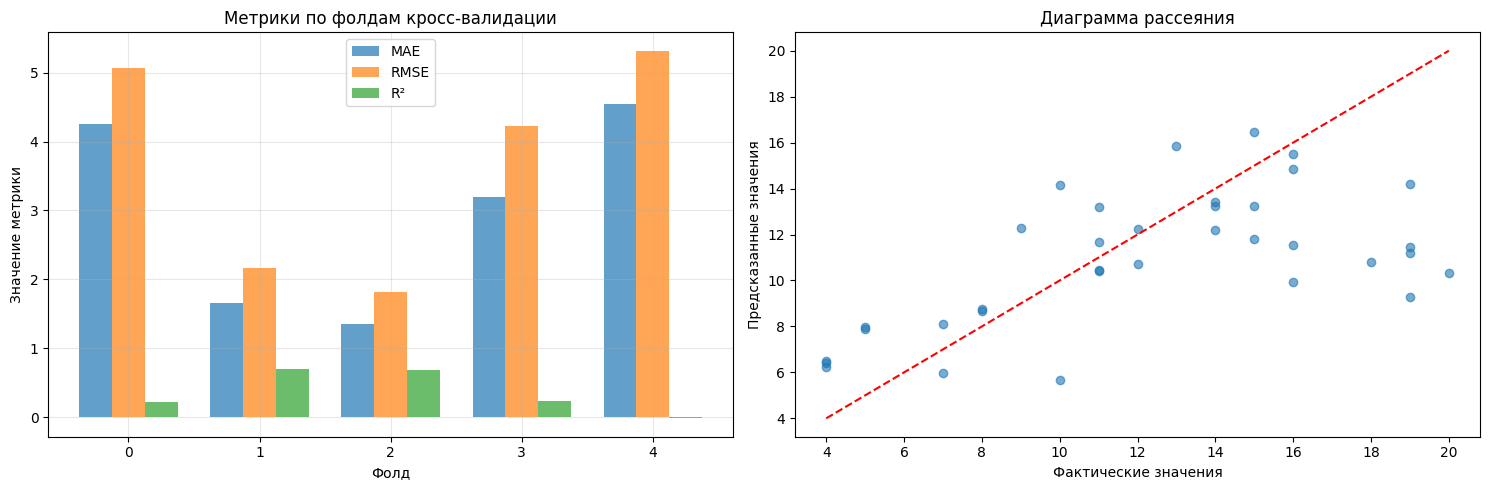

In [128]:
# Визуализация по фолдам
results_df = pd.DataFrame(fold_scores)

plt.figure(figsize=(15, 5))

# График 1: Метрики по фолдам
plt.subplot(1, 2, 1)
x_pos = np.arange(len(results_df))
width = 0.25

plt.bar(x_pos - width, results_df['mae'], width, label='MAE', alpha=0.7)
plt.bar(x_pos, results_df['rmse'], width, label='RMSE', alpha=0.7)
plt.bar(x_pos + width, results_df['r2'], width, label='R²', alpha=0.7)

plt.xlabel('Фолд')
plt.ylabel('Значение метрики')
plt.title('Метрики по фолдам кросс-валидации')
plt.legend()
plt.grid(True, alpha=0.3)

# График 2: Фактические vs Предсказанные значения
plt.subplot(1, 2, 2)
plt.scatter(actuals, predictions, alpha=0.6)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--')
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Диаграмма рассеяния')

plt.tight_layout()
plt.show()

Средний MAE по фолдам: 3.00 ± 1.46
Средний R² по фолдам: 0.368 ± 0.316


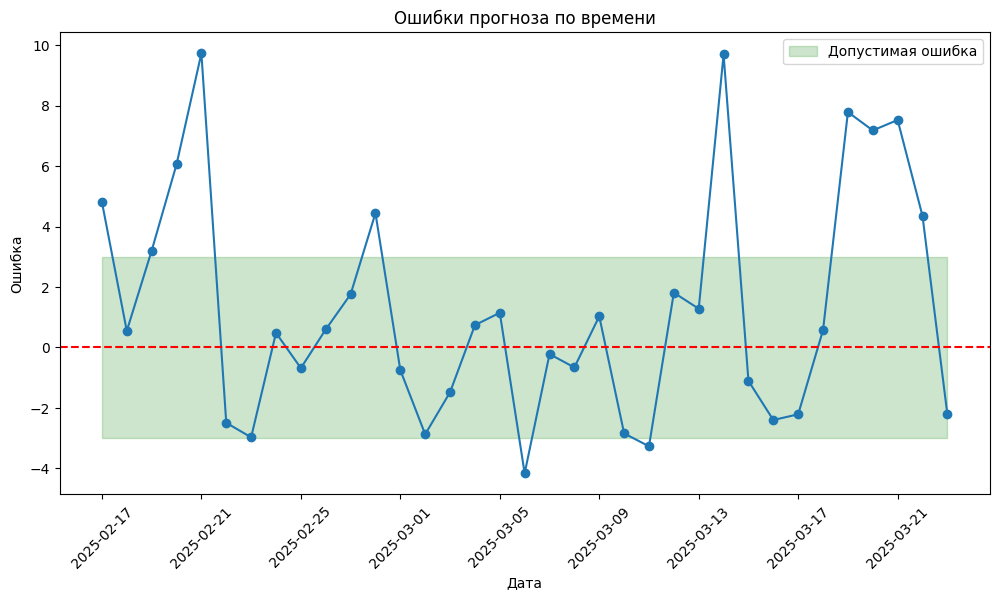

In [151]:
stability_analysis = pd.DataFrame({
    'date': dates,
    'actual': actuals,
    'predicted': predictions,
    'error': np.array(actuals) - np.array(predictions)
})

print(f"Средний MAE по фолдам: {results_df['mae'].mean():.2f} ± {results_df['mae'].std():.2f}")
print(f"Средний R² по фолдам: {results_df['r2'].mean():.3f} ± {results_df['r2'].std():.3f}")

plt.figure(figsize=(12, 6))
plt.plot(stability_analysis['date'], stability_analysis['error'], marker='o')
plt.axhline(y=0, color='red', linestyle='--')
plt.fill_between(stability_analysis['date'],
                 -results_df['mae'].mean(),
                 results_df['mae'].mean(),
                 alpha=0.2, color='green', label='Допустимая ошибка')
plt.title('Ошибки прогноза по времени')
plt.xlabel('Дата')
plt.ylabel('Ошибка')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [130]:
def predict_future(model, last_date, features_data, days=7):
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days)
    future_predictions = []

    current_features = features_data.iloc[-1:].copy()

    for i, date in enumerate(future_dates):
        current_features['date'] = date
        current_features['day_of_week'] = date.dayofweek
        current_features['month'] = date.month
        current_features['year'] = date.year
        current_features['day_of_year'] = date.dayofyear
        current_features['weekend'] = 1 if date.dayofweek in [5, 6] else 0

        pred = model.predict(current_features[features])[0]
        future_predictions.append(pred)

        if i < days - 1:
            current_features['lag_3'] = current_features['lag_2']
            current_features['lag_2'] = current_features['lag_1']
            current_features['lag_1'] = pred

    return future_dates, future_predictions

last_date = daily_sales_features['date'].max()
future_dates, future_predictions = predict_future(
    ensemble, last_date, daily_sales_features, days=7
)

print("ПРОГНОЗ НА 7 ДНЕЙ:")
for date, pred in zip(future_dates, future_predictions):
    print(f"{date.strftime('%Y-%m-%d')}: {pred:.1f} продаж")

ПРОГНОЗ НА 7 ДНЕЙ:
2025-03-24: 12.2 продаж
2025-03-25: 11.8 продаж
2025-03-26: 11.7 продаж
2025-03-27: 10.3 продаж
2025-03-28: 10.2 продаж
2025-03-29: 7.3 продаж
2025-03-30: 7.0 продаж


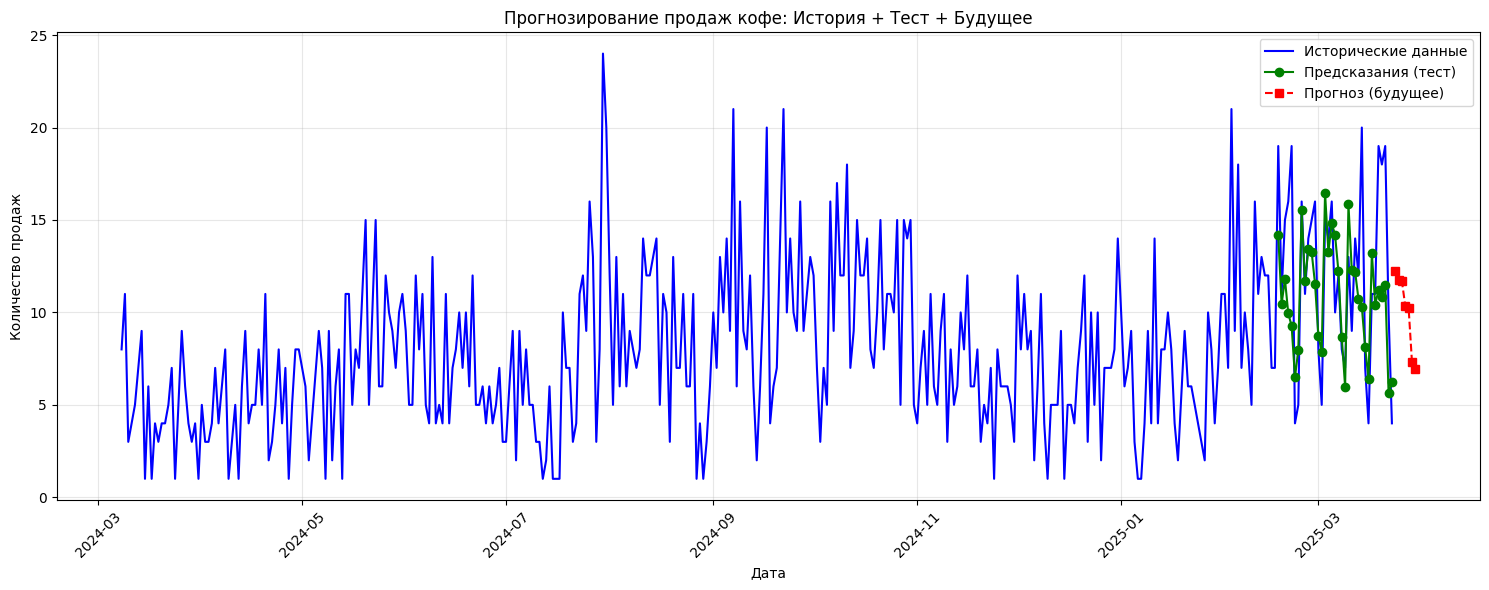

In [131]:
plt.figure(figsize=(15, 6))

plt.plot(daily_sales_features['date'],
         daily_sales_features['coffee_count'],
         label='Исторические данные', color='blue')

plt.plot(results['date'], results['predicted'],
         label='Предсказания (тест)', color='green', marker='o')

plt.plot(future_dates, future_predictions,
         label='Прогноз (будущее)', color='red', marker='s', linestyle='--')

plt.title('Прогнозирование продаж кофе: История + Тест + Будущее')
plt.xlabel('Дата')
plt.ylabel('Количество продаж')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Вывод:
Эксперимент интересный, считаю, что стоит подумать в сторону увеличения данных и использования более сложных моделей (к примеру, LSTM (GRU)), тогда возможно будет метрики улучшить